In [16]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.font_manager as fm

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

font_path = 'C:\\Windows\\Fonts\\gulim.ttc'
font = fm.FontProperties(fname=font_path).get_name()
plt.rc('font', family=font)

In [17]:
# 데이터 로드 , 구조 확인
df = pd.read_csv('listings.csv.gz', compression='gzip')

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25297 entries, 0 to 25296
Data columns (total 79 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   id                                            25297 non-null  int64  
 1   listing_url                                   25297 non-null  object 
 2   scrape_id                                     25297 non-null  int64  
 3   last_scraped                                  25297 non-null  object 
 4   source                                        25297 non-null  object 
 5   name                                          25297 non-null  object 
 6   description                                   24879 non-null  object 
 7   neighborhood_overview                         14048 non-null  object 
 8   picture_url                                   25297 non-null  object 
 9   host_id                                       25297 non-null 

In [18]:

'''
price                   1박당 가격
room_type               숙소 유형 (집 전체, 개인실, 다인실)
accommodates            최대 수용 가능 인원
bedrooms                침실 개수
beds                    침대 개수
review_scores_rating    전체 만족도 평점
neighbourhood_cleansed  표준화된 지역명

'''
# 정제
cols = [
        'price', 'room_type', 'accommodates', 'bedrooms', 'beds',
        'review_scores_rating', 'neighbourhood_cleansed'
    ]
df_eda = df[cols].copy()

# price 컬럼 숫자 형태로 변환
df_eda['price'] = pd.to_numeric(df_eda['price'].str.replace('[$,]', '', regex=True), errors='coerce') # error='coerce' -> 변환 과정에 강제 nan 값 변환

# 결측치 처리
df_eda.dropna(subset=['price', 'review_scores_rating'], inplace=True) # 가격 , 리뷰점수 결측치 행 제거

for col in ['bedrooms', 'beds']: # badrooms , beds 결측치 중앙값
    median_val = df_eda[col].median()
    df_eda[col] = df_eda[col].fillna(median_val)


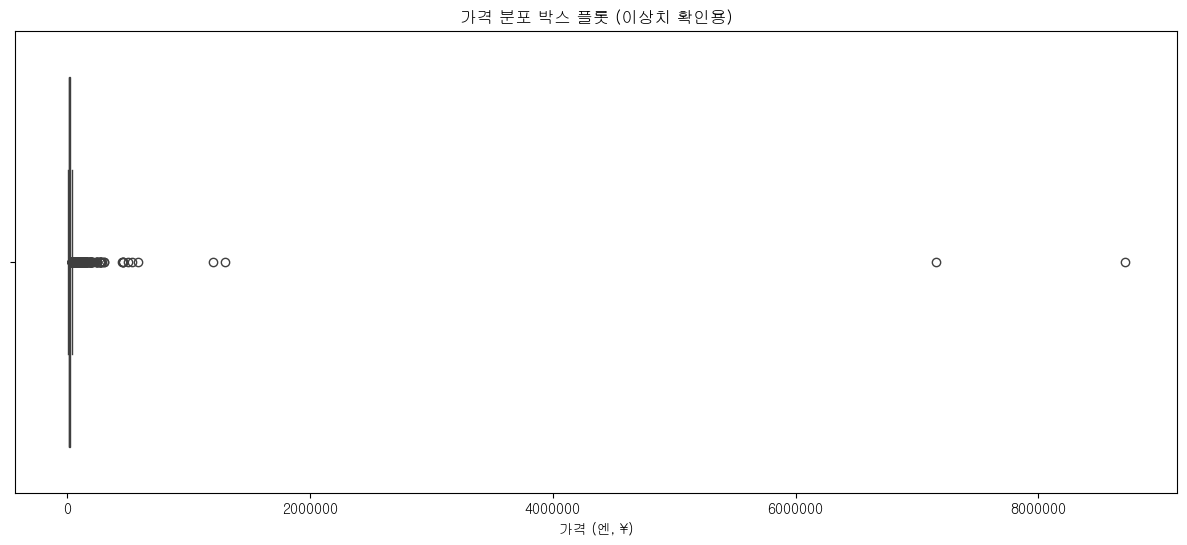

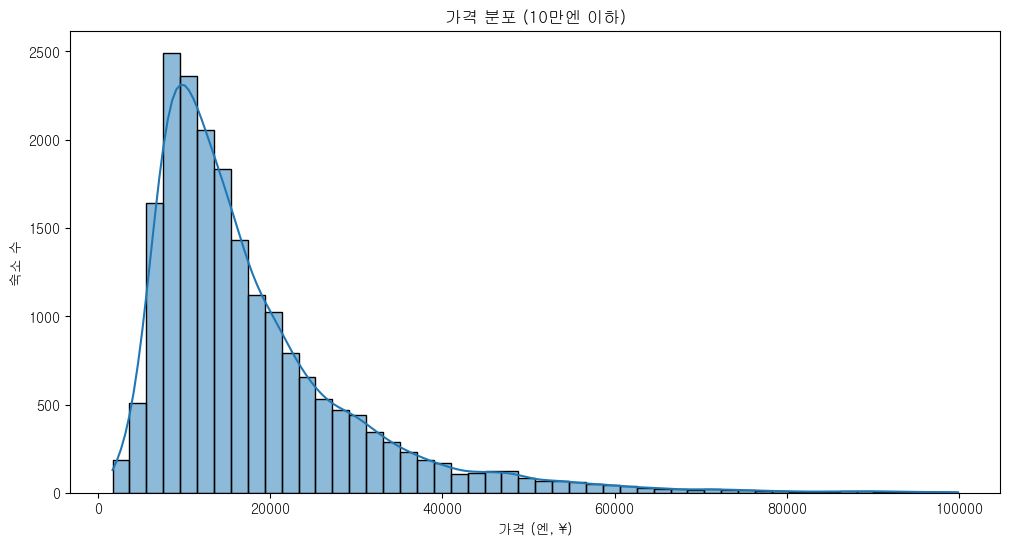

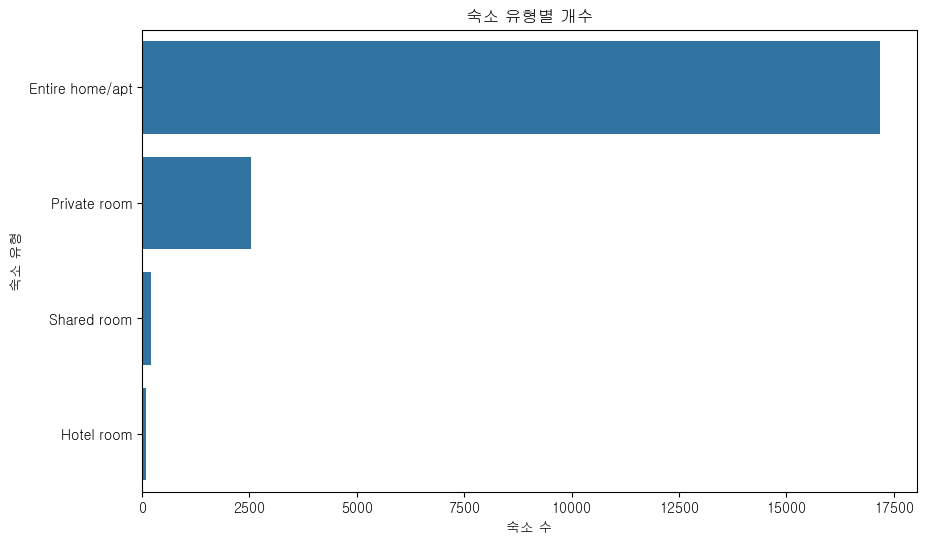

neighbourhood_cleansed
Hinohara Mura    31766.500000
Shibuya Ku       30319.971927
Minato Ku        26554.069799
Shinjuku Ku      24671.506890
Akiruno Shi      24101.928571
Chiyoda Ku       23228.544503
Meguro Ku        22587.716814
Chuo Ku          22311.095618
Taito Ku         21601.575494
Kunitachi Shi    21001.545455
Name: price, dtype: float64


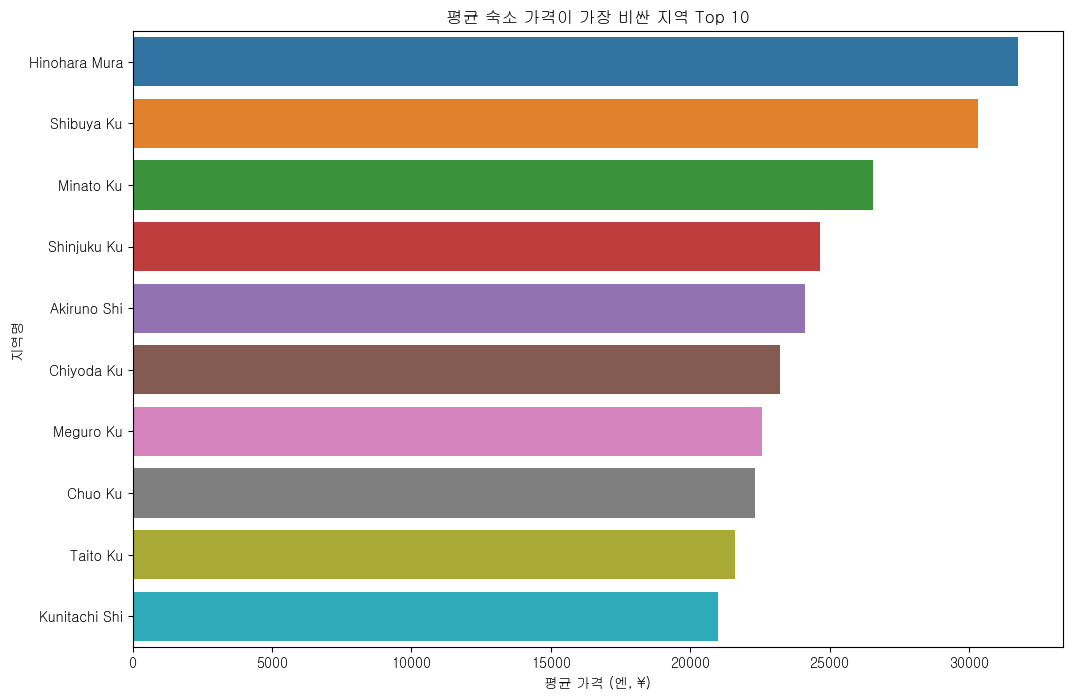

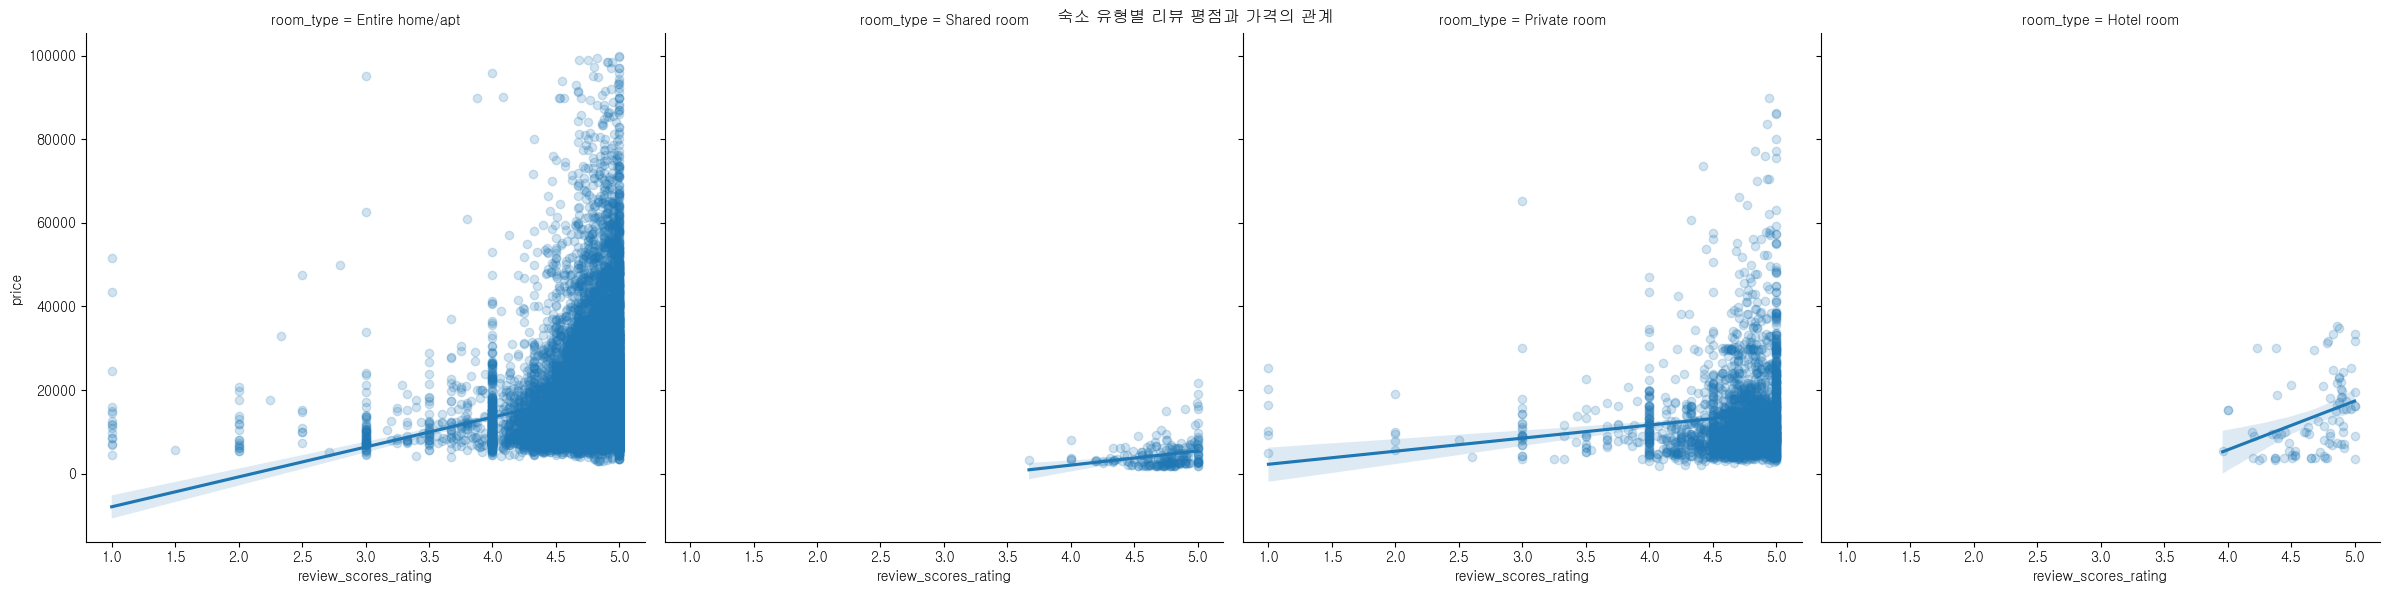

In [19]:
 #데이터 탐색

# 전체 가격 
plt.figure(figsize=(15, 6))
sns.boxplot(x=df_eda['price'])
plt.title('가격 분포 박스 플롯 (이상치 확인용)')
plt.xlabel('가격 (엔, ¥)')
plt.ticklabel_format(style='plain', axis='x')
plt.show()

# 10만엔 이하 필터하여 체크
plt.figure(figsize=(12, 6))
sns.histplot(df_eda[df_eda['price'] < 100000]['price'], bins=50, kde=True)
plt.title('가격 분포 (10만엔 이하)')
plt.xlabel('가격 (엔, ¥)')
plt.ylabel('숙소 수')
plt.show()

# 숙소 유형별 개수 
plt.figure(figsize=(10, 6))
sns.countplot(y='room_type', data=df_eda, order=df_eda['room_type'].value_counts().index)
plt.title('숙소 유형별 개수')
plt.xlabel('숙소 수')
plt.ylabel('숙소 유형')
plt.show()

# 평균 숙소 가격이 가장 비싼 지역 Top 10개 
avg_price_by_neighbourhood = df_eda.groupby('neighbourhood_cleansed')['price'].mean() #cleansed 컬럼으로 묶고 pircde 평균 계산
expensive_hoods = avg_price_by_neighbourhood.sort_values(ascending=False).head(10) # 평균 가격 정렬 , 10개만 선택
print(expensive_hoods)
plt.figure(figsize=(12, 8))
sns.barplot(x=expensive_hoods.values, y=expensive_hoods.index, hue=expensive_hoods.index, legend=False)
plt.title('평균 숙소 가격이 가장 비싼 지역 Top 10')
plt.xlabel('평균 가격 (엔, ¥)')
plt.ylabel('지역명')
plt.show()

# 숙소 유형별 가격 리뷰 점수 체크 
sns.lmplot(x='review_scores_rating', y='price', col='room_type', data=df_eda[df_eda['price'] < 100000], 
           scatter_kws={'alpha':0.2}, height=6) # 칼럼은 룸 타입에 리뷰점수 , 가격 체크 , 100000엔 미만
plt.suptitle('숙소 유형별 리뷰 평점과 가격의 관계')
plt.show()

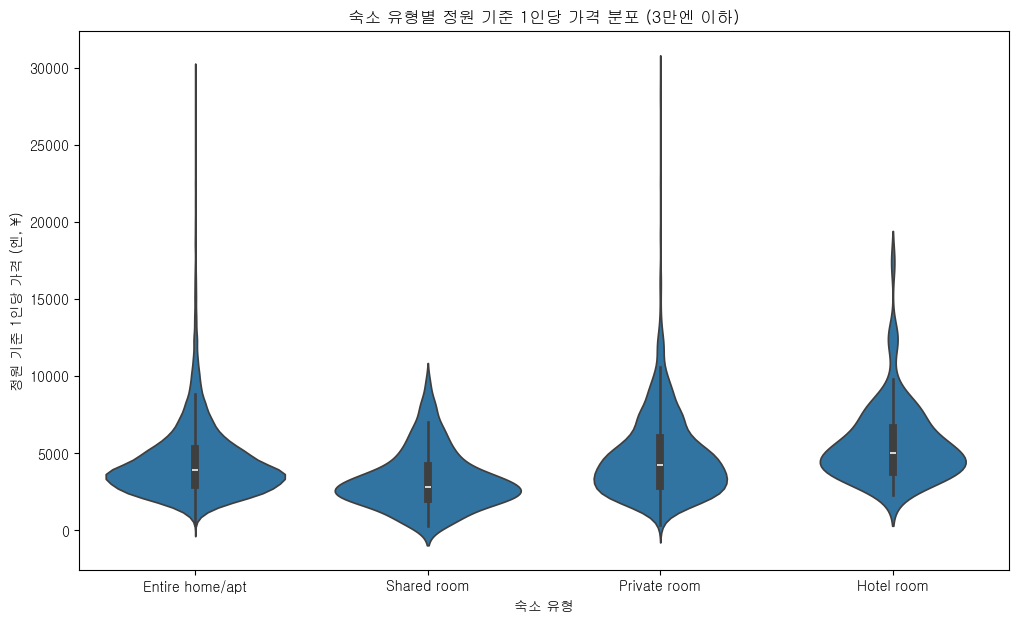

In [20]:
# 별개로 숙소 가성비 비교 칼럼 
df_eda['price_per_person'] = df_eda['price'] / df_eda['accommodates'] # 칼럼 생성 -> price / accommodates
df_eda['price_per_person'] = df_eda['price_per_person'].replace([np.inf, -np.inf], 0) # 기존 0 데이터가 무한대로 인식해서 0으로 수정
df_eda['price_per_person'] = df_eda['price_per_person'].fillna(0) # 빈칸을 0으로 

# 각 숙소 유형별로 어떤 가격에 몰려 있는지 확인
plt.figure(figsize=(12, 7))
sns.violinplot(x='room_type', y='price_per_person', data=df_eda[df_eda['price_per_person'] < 30000])
plt.title('숙소 유형별 정원 기준 1인당 가격 분포 (3만엔 이하)')
plt.xlabel('숙소 유형')
plt.ylabel('정원 기준 1인당 가격 (엔, ¥)')
plt.show()


In [21]:
# 모델링

X = df_eda.drop('price', axis=1)
y = df_eda['price']

X_encoded = pd.get_dummies(X, columns=['room_type', 'neighbourhood_cleansed'], drop_first=True) 
# roomtype 이 비교 했을때 제일 중요 할 거 같음

X_train, X_test, y_train, y_test = train_test_split(
    X_encoded, y, test_size=0.2, random_state=42
)

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(16013, 56) (16013,)
(4004, 56) (4004,)


In [22]:
# 모델 훈련 및 평가

lr = LinearRegression()
lr.fit(X_train, y_train)
pred = lr.predict(X_test)

score = lr.score(X_test, y_test)

print(score)

0.05119574839327212
